# Groundtruth training on focused edges (training 1)

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Presentation

For each different training we proceed as follow:

Step 1: random search or bayesian search over a lot of models and parameters\
Step 2: evaluate the 3 best models with cross validation and chose the best out of the 3

For the seed, we always take the same seed: 100

## Setup

In [63]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imageio

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import keras_tuner as kt

from amftrack.ml.width.models import (
    hyper_model_builder_simple,
    build_model_dense,
    build_model_conv,
    build_model_conv_small,
)
from amftrack.util.sys import storage_path
from amftrack.ml.width.data_augmentation import data_augmentation, data_preparation
from keras.utils.layer_utils import count_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
%reload_ext autoreload

### Fetch data

Repository with all possible datasets

In [7]:
dataset_path = os.path.join(storage_path, "datasets")

Two datasets that I have choosen to use

In [8]:
focused_dataset_path = os.path.join(
    dataset_path, "focused_with_varying_lum_train"
)  # dataset with varying lumination but consistent focus
extended_dataset_path = os.path.join(
    dataset_path, "varying_lum_and_focus_train"
)  # dataset with varying lumination but consistent focus

For now: using the focused dataset

In [9]:
path = focused_dataset_path

In [10]:
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [11]:
im = imageio.imread(im_path)
print(im.shape)

(527, 120)


In [12]:
with open(label_path, "rb") as f:
    label = np.load(f)
print(label.shape)

(527,)


In [13]:
label = np.expand_dims(label, axis=1)

In [14]:
label.shape

(527, 1)

### Data preparation

For seperating the test set (not used for now as the test is done in another notebook²)

In [15]:
seed = 11
np.random.seed(11)
p = np.random.permutation(len(label))
training = p[:-150]
valid = p[-150:]
print(len(training))
print(len(valid))

377
150


In [16]:
train_feature = im[training, :]
train_label = label[training, :]
valid_feature = im[valid, :]
valid_label = label[valid, :]

Instead we just take it all

In [17]:
train_feature.shape

(377, 120)

### Visualisation

In [18]:
i = 300

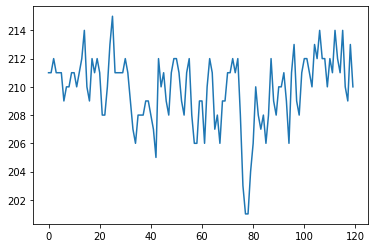

In [19]:
plt.plot(im[i, :])

In [20]:
label[i, :]

array([3.54463004])

## Mean predicting model

In [21]:
train_label.shape

(377, 1)

In [22]:
np.var(train_label)

4.982430809438182

In [23]:
np.std(train_label)

2.2321359298748322

In [24]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean((train_label - pred) ** 2)
print(f"Mean is: {mean}, Mean squarred error is: {res}")

Mean is: 5.279759580329631, Mean squarred error is: 4.982430809438182


In [25]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean(abs(train_label - pred))
print(f"Mean is: {mean}, Mean absolute error is: {res}")

Mean is: 5.279759580329631, Mean absolute error is: 1.5887181524020357


## Data preprocessing

### Train dataset

In [70]:
from amftrack.ml.width.data_augmentation import (
    data_preparation,
    data_augmentation,
    random_crop,
    random_mirror,
    random_invert,
    random_brightness,
)

In [71]:
train_feature.shape

(377, 120)

PROPRE

In [72]:
train_feature_ds = np.expand_dims(train_feature, axis=-1)
train_feature_ds = np.expand_dims(train_feature_ds, axis=-3)

In [73]:
train_feature_ds.shape

(377, 1, 120, 1)

In [74]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(train_label)
train_ds = tf.data.Dataset.zip((d1, d2))

In [75]:
# TEST
d1

<TensorSliceDataset element_spec=TensorSpec(shape=(1, 120, 1), dtype=tf.uint8, name=None)>

In [76]:
# TEST
d2

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>

In [77]:
# TEST
train_label.shape

(377, 1)

In [78]:
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    # .unbatch()
    .batch(16).prefetch(tf.data.AUTOTUNE)
)

In [79]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

TEST

In [80]:
for e in train_ds:
    break

In [81]:
np.array(e[0]).shape

(16, 1, 100, 1)

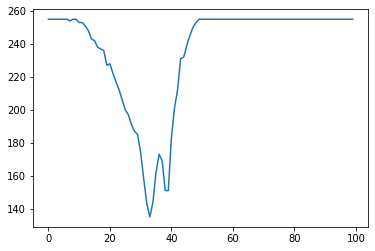

In [82]:
plt.plot(np.array(e[0][0, 0, :, 0]))

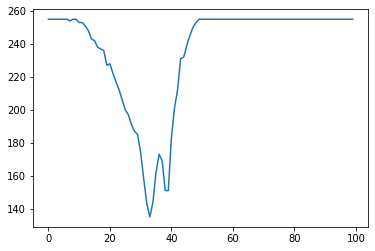

In [83]:
plt.plot(np.array(e[0][0, 0, :, 0]))

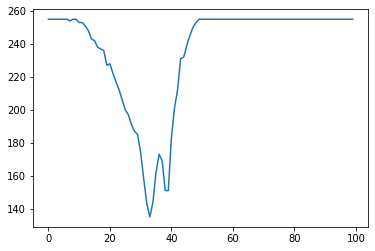

In [84]:
plt.plot(np.array(e[0][0, 0, :, 0]))

### Test dataset

In [85]:
valid_feature_ds = np.expand_dims(valid_feature, axis=-1)
valid_feature_ds = np.expand_dims(valid_feature_ds, axis=-3)
d1 = tf.data.Dataset.from_tensor_slices(valid_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(valid_label)
valid_ds = tf.data.Dataset.zip((d1, d2))
valid_ds = (
    valid_ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [86]:
for e in valid_ds:
    print(e)
    break

(<tf.Tensor: shape=(16, 100, 1), dtype=float32, numpy=
array([[[140.],
        [138.],
        [142.],
        ...,
        [132.],
        [134.],
        [132.]],

       [[185.],
        [185.],
        [189.],
        ...,
        [175.],
        [175.],
        [173.]],

       [[165.],
        [164.],
        [164.],
        ...,
        [166.],
        [168.],
        [167.]],

       ...,

       [[224.],
        [224.],
        [223.],
        ...,
        [216.],
        [220.],
        [217.]],

       [[255.],
        [254.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[150.],
        [150.],
        [148.],
        ...,
        [144.],
        [144.],
        [145.]]], dtype=float32)>, <tf.Tensor: shape=(16,), dtype=float64, numpy=
array([5.24173503, 4.34090199, 3.71157107, 8.97995119, 5.29939395,
       5.29939395, 5.4984222 , 2.85702873, 5.35827466, 4.18356936,
       4.34090199, 3.06895321, 4.45399496, 4.67930649, 4.88385177,
 

## Training a model

In [87]:
build_function = build_model_conv_small

### 1/ Run hyperparameter search

In [88]:
hp = kt.HyperParameters()
hp.Fixed("input_size", 100)

100

Randomgridsearch tuner

Other tuner:

In [94]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model_conv,  # CAREFUL
    objective="val_mean_absolute_error",
    max_trials=1,
    max_model_size=5000000,  # CAREFUL
    num_initial_points=50,
    alpha=0.0001,
    beta=2.6,  # explorative factor
    seed=seed,
    hyperparameters=hp,
    allow_new_entries=True,
    tune_new_entries=True,
    overwrite=True,
)

Without augmentation:

Actual search

In [95]:
tuner.search(
    train_ds,
    validation_data=valid_ds,
    epochs=150,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)],
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
100               |?                 |input_size
0.00079119        |?                 |regul
2                 |?                 |conv_blocks
32                |?                 |filters_0
15                |?                 |kernel_size0
1                 |?                 |strides
136               |?                 |filters_1
5                 |?                 |kernel_size1
70                |?                 |hidden_size
3                 |?                 |dense_blocks
0.05              |?                 |dropout
0.056138          |?                 |learning_rate
False             |?                 |batch_normalization
none              |?                 |pooling_1

Epoch 1/150


2022-08-18 18:14:27.475118: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:675 : INVALID_ARGUMENT: Computed output size would be negative: -13 [input_size: 1, effective_filter_size: 15, stride: 1]


InvalidArgumentError: Graph execution error:

Detected at node 'model/conv1d/Conv1D' defined at (most recent call last):
    File "/usr/local/lib/python3.8/runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/lib/python3.8/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/lib/python3.8/asyncio/base_events.py", line 563, in run_forever
      self._run_once()
    File "/usr/local/lib/python3.8/asyncio/base_events.py", line 1844, in _run_once
      handle._run()
    File "/usr/local/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_13858/1510589327.py", line 1, in <cell line: 1>
      tuner.search(train_ds,
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras_tuner/engine/base_tuner.py", line 179, in search
      results = self.run_trial(trial, *fit_args, **fit_kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 294, in run_trial
      obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 222, in _build_and_fit_model
      results = self.hypermodel.fit(hp, model, *args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras_tuner/engine/hypermodel.py", line 137, in fit
      return model.fit(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d/Conv1D'
Computed output size would be negative: -13 [input_size: 1, effective_filter_size: 15, stride: 1]
	 [[{{node model/conv1d/Conv1D}}]] [Op:__inference_train_function_8904]

### 2/ Analyse hyperparameter search results

#### Search space

In [355]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
input_size (Fixed)
{'conditions': [], 'value': 100}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
conv_blocks (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max', 'none'], 'ordered': False}
hidden_size (Int)
{

#### Best models

In [356]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 100
regul: 0.00032199506051567314
batch_normalization: True
conv_blocks: 2
filters_0: 64
kernel_size0: 13
filters_1: 160
kernel_size1: 5
pooling_1: avg
hidden_size: 74
dense_blocks: 2
dropout: 0.30000000000000004
learning_rate: 0.00020644391295639603
pooling_0: none
Score: 0.7165171504020691
Trial summary
Hyperparameters:
input_size: 100
regul: 0.00020843798952555745
batch_normalization: True
conv_blocks: 2
filters_0: 128
kernel_size0: 20
filters_1: 192
kernel_size1: 5
pooling_1: avg
hidden_size: 74
dense_blocks: 3
dropout: 0.2
learning_rate: 0.00037799533912759005
pooling_0: none
filters_2: 32
kernel_size2: 13
pooling_2: avg
Score: 0.7778459191322327
Trial summary
Hyperparameters:
input_size: 100
regul: 0.0007469179347180683
batch_normalization: True
conv_blocks: 2
filters_0: 32
kernel_size0: 20
filters_1: 128
kernel_size1: 5
pooling_1: max
hidden_size: 74
dense_blocks: 2
dr

In [357]:
best_models = tuner.get_best_models(10)

2022-08-18 12:51:24,039-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-18 12:51:24,040-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-18 12:51:24,041-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-18 12:51:24,042-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-18 12:51:24,043-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-18 12:51:24,045-[WARNI

2022-08-18 12:51:24,108-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-18 12:51:24,109-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-18 12:51:24,110-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-18 12:51:24,111-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-18 12:51:24,115-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-18 12:51:24,116-[WARNI

2022-08-18 12:51:24,166-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-18 12:51:24,168-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-18 12:51:24,169-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-18 12:51:24,170-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-18 12:51:24,172-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.learning_rate


In [358]:
best_hyperparameters = tuner.get_best_hyperparameters(10)

#### Best model

In [359]:
best_model = best_models[0]

In [360]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 rescaling (Rescaling)       (None, 100, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 91, 64)            704       
                                                                 
 batch_normalization (BatchN  (None, 91, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 91, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 160)           102560    
                                                             

In [361]:
best_hyperparameters[0].values

{'input_size': 100,
 'regul': 0.00032199506051567314,
 'batch_normalization': True,
 'conv_blocks': 2,
 'filters_0': 64,
 'kernel_size0': 13,
 'filters_1': 160,
 'kernel_size1': 5,
 'pooling_1': 'avg',
 'hidden_size': 74,
 'dense_blocks': 2,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.00020644391295639603,
 'pooling_0': 'none'}

#### Size of best models

In [362]:
for i in range(10):
    print(f"Model {i}")
    print(count_params(best_models[i].trainable_weights))
    print()

Model 0
594851

Model 1
841777

Model 2
435811

Model 3
543235

Model 4
981845

Model 5
1090769

Model 6
439153

Model 7
117585

Model 8
1738481

Model 9
1090769



#### Visualize prediction on the validation set

In [363]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker="o")
    plt.plot([0, 12], [0, 12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

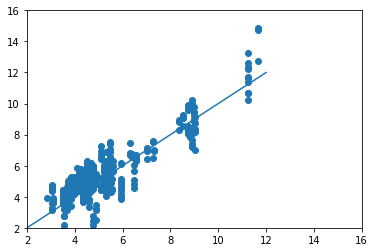

In [460]:
plot_against(best_model, data_preparation(train_feature), train_label)

In [365]:
best_model.evaluate(data_preparation(valid_feature), valid_label)

5/5 [==============================] - 0s 7ms/step - loss: 2.9143 - mean_absolute_error: 0.7165


[2.9142723083496094, 0.7165171504020691]

In [366]:
valid_feature.shape

(150, 120)

### 3/ Evaluate the best models with cross validation

valid_e is the validation set for early stopping\
valid is the validation set to evaluate a split

#### Model hyperparameter

**a. From a saved dictionnary**

In [461]:
def make_fixed_hp_from_dict(d):
    ĥp = kt.HyperParameters()
    for key in d.keys():
        hp.Fixed(key, d[key])
    return hp

In [462]:
hp = make_fixed_hp_from_dict(best_config)

**b. From a hyperparameter instance**

In [463]:
hp = best_hyperparameters[3]

#### Model

In [450]:
new_model = build_function(hp)

In [451]:
new_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 rescaling_5 (Rescaling)     (None, 100, 1)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 91, 32)            352       
                                                                 
 batch_normalization_7 (Batc  (None, 91, 32)           128       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 91, 32)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 82, 160)           51360     
                                                           

#### Cross validation

Creating the datasets

In [452]:
train_feature_ds = np.expand_dims(train_feature, axis=-1)
train_feature_ds = np.expand_dims(train_feature_ds, axis=-3)
d1 = tf.data.Dataset.from_tensor_slices(train_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(train_label)
train_ds = tf.data.Dataset.zip((d1, d2))
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [453]:
valid_feature_ds = np.expand_dims(valid_feature, axis=-1)
valid_feature_ds = np.expand_dims(valid_feature_ds, axis=-3)
d1 = tf.data.Dataset.from_tensor_slices(valid_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(valid_label)
valid_ds = tf.data.Dataset.zip((d1, d2))
valid_ds = (
    valid_ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [454]:
def numpy_to_ds(feature, label):
    feature_ds = np.expand_dims(feature, axis=-1)
    feature_ds = np.expand_dims(feature_ds, axis=-3)
    d1 = tf.data.Dataset.from_tensor_slices(feature_ds)
    d2 = tf.data.Dataset.from_tensor_slices(label)
    ds = tf.data.Dataset.zip((d1, d2))
    ds = (
        ds.map(lambda x, y: (data_augmentation(x, training=True), y))
        .unbatch()
        .batch(16)
        .prefetch(tf.data.AUTOTUNE)
    )
    return ds

In [455]:
def numpy_to_ds_preparation(feature, label):
    feature_ds = np.expand_dims(feature, axis=-1)
    feature_ds = np.expand_dims(feature_ds, axis=-3)
    d1 = tf.data.Dataset.from_tensor_slices(feature_ds)
    d2 = tf.data.Dataset.from_tensor_slices(label)
    ds = tf.data.Dataset.zip((d1, d2))
    ds = (
        ds.map(lambda x, y: (data_preparation(x, training=True), y))
        .unbatch()
        .batch(16)
        .prefetch(tf.data.AUTOTUNE)
    )
    return ds

In [456]:
hp.values["learning_rate"]

0.0005581019820643

In [457]:
def generalisation_estimator(model, hp, n_split=4):
    evaluations = []
    history = []
    for train_g, valid in KFold(n_split).split(training):
        train, valid_e = next(KFold(n_split).split(train_g))
        train_feature = im[train, :]
        train_label = label[train, :]
        valid_e_feature = im[valid_e, :]
        valid_e_label = label[valid_e, :]
        valid_feature = im[valid, :]
        valid_label = label[valid, :]

        train_ds = numpy_to_ds(train_feature, train_label)
        valid_e_ds = numpy_to_ds_preparation(valid_e_feature, valid_e_label)
        # valid_ds = numpy_to_ds_preparation(valid_feature, valid_label)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.values["learning_rate"]),
            loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
            metrics=[tf.keras.metrics.mean_absolute_error],
        )

        print(valid_e)

        history.append(
            model.fit(
                train_ds,
                validation_data=valid_e_ds,
                # batch_size=16,
                epochs=200,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)]  # CAREFUL
                # validation_data = (data_preparation(valid_e_feature), valid_e_label),
            )
        )
        evaluations.append(model.evaluate(data_preparation(valid_feature), valid_label))

    return model, history, evaluations

In [458]:
model, history, evaluations = generalisation_estimator(new_model, hp)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Epoch 1/200
14/14 [==============================] - 1s 29ms/step - loss: 7.2616 - mean_absolute_error: 1.8243 - val_loss: 31.4294 - val_mean_absolute_error: 5.1296
Epoch 2/200
14/14 [==============================] - 0s 18ms/step - loss: 3.3958 - mean_absolute_error: 1.2820 - val_loss: 30.7947 - val_mean_absolute_error: 5.0764
Epoch 3/200
14/14 [==============================] - 0s 19ms/step - loss: 3.9612 - mean_absolute_error: 1.4288 - val_loss: 30.3231 - val_mean_absolute_error: 5.0374
Epoch 4/200
14/14 [==============================] - 0s 23ms/step - loss: 3.4857 - mean_absolute_error: 1.3351 - val_loss: 29.7732 - val_mean_absolute_error: 4.9913
Epoch 5/200
14/14 [==============================] - 0s 20ms/step - loss: 3.1162 - mean_absolute_error: 1.2479 - val_loss: 

14/14 [==============================] - 0s 18ms/step - loss: 1.7211 - mean_absolute_error: 0.8417 - val_loss: 3.7359 - val_mean_absolute_error: 1.4919
Epoch 50/200
14/14 [==============================] - 0s 18ms/step - loss: 1.7844 - mean_absolute_error: 0.8199 - val_loss: 2.8969 - val_mean_absolute_error: 1.1963
Epoch 51/200
14/14 [==============================] - 0s 18ms/step - loss: 1.7130 - mean_absolute_error: 0.8373 - val_loss: 2.6819 - val_mean_absolute_error: 1.2065
Epoch 52/200
14/14 [==============================] - 0s 18ms/step - loss: 1.8507 - mean_absolute_error: 0.9011 - val_loss: 2.2328 - val_mean_absolute_error: 1.0230
Epoch 53/200
14/14 [==============================] - 0s 19ms/step - loss: 1.7001 - mean_absolute_error: 0.8477 - val_loss: 2.5709 - val_mean_absolute_error: 1.1648
Epoch 54/200
14/14 [==============================] - 0s 17ms/step - loss: 1.7931 - mean_absolute_error: 0.8526 - val_loss: 2.8983 - val_mean_absolute_error: 1.2150
Epoch 55/200
14/14 [===

In [443]:
acc = [e[1] for e in evaluations]
mean = np.mean(acc)
std_dev = np.std(acc)
print(f"Mean: {mean} Std: {std_dev}")

Mean: 2.907501369714737 Std: 1.8429777684483992


In [444]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

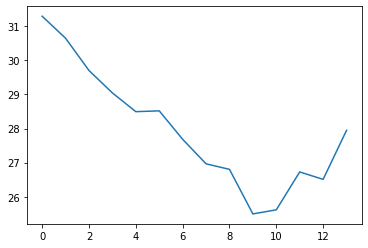

In [445]:
plt.plot(history[0].history["val_loss"])

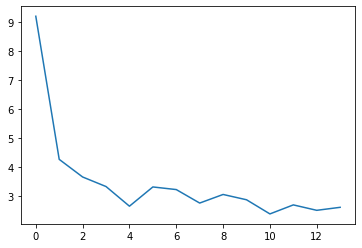

In [446]:
plt.plot(history[0].history["loss"])

In [447]:
best_hyperparameters[0].values

{'input_size': 100,
 'regul': 0.00032199506051567314,
 'batch_normalization': True,
 'conv_blocks': 2,
 'filters_0': 64,
 'kernel_size0': 13,
 'filters_1': 160,
 'kernel_size1': 5,
 'pooling_1': 'avg',
 'hidden_size': 74,
 'dense_blocks': 2,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.00020644391295639603,
 'pooling_0': 'none'}

#### Results

Run for the dense function

Conclusion: keeping model 2

### 4/ Retrain the best model on all the training data

#### Intel on the model

In [323]:
hp = best_hyperparameters[1]
model = build_model_dense(hp)

In [324]:
name = "dense_02_focused_edge"

In [325]:
info = f"""
Trained on focused slices with illumination variation:
{path}

Hyperparameters:
{str(hp.values)}
 
Cross validation results:
Mean: 0.759149506688118 Std: 0.0460086760081415

Size: {count_params(model.trainable_weights)}

Training on {len(training)} points and {len(im) - len(training)} used for early stopping validation.

Input size: 100

Data augmentation: random_crop + random_mirror
"""

In [326]:
print(info)


Trained on focused slices with illumination variation:
/media/felix/AMFtopology02/storage/datasets/focused_with_varying_lum_train

Hyperparameters:
{'input_size': 100, 'hidden_size': 42, 'regul': 0.0036787999149105136, 'dense_blocks': 9, 'dropout': 0.0, 'learning_rate': 0.0003168240557749865}
 
Cross validation results:
Mean: 0.759149506688118 Std: 0.0460086760081415

Size: 18733

Training on 377 points and 150 used for early stopping validation.

Input size: 100

Data augmentation: random_crop + random_mirror



#### Saving location

In [327]:
model_path = os.path.join(storage_path, "models", name)

In [328]:
model_path

'/media/felix/AMFtopology02/storage/models/dense_02_focused_edge'

In [330]:
os.mkdir(model_path)

In [331]:
with open(os.path.join(model_path, "info_general.txt"), "w") as f:
    f.write(info)

#### Callbacks

In [332]:
from amftrack.ml.callbacks import SavePlots

In [333]:
tensorboard_path = os.path.join(os.path.dirname(model_path), "tensorboard")
tb_callback = tf.keras.callbacks.TensorBoard(tensorboard_path, update_freq=5)

In [334]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    verbose=0,
    restore_best_weights=True,
)

In [335]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=6,
    verbose=0,
    min_delta=0.001,
    cooldown=0,
)

In [336]:
plot_callback = SavePlots(model_path)

In [337]:
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(model_path, "training.log"))

In [338]:
callbacks = [
    csv_logger,
    # reduce_lr_callback,
    early_stopping_callback,
    tb_callback,
    plot_callback,
]

#### Training

Full dataset

In [339]:
model.fit(train_ds, validation_data=valid_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
 1/24 [>.............................] - ETA: 14s - loss: 42.4254 - mean_absolute_error: 5.1726WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_train_batch_end` time: 0.0033s). Check your callbacks.
2022-08-18 12:03:18,340-[WARNING]- tensorflow:339 -> Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_train_batch_end` time: 0.0033s). Check your callbacks.
24/24 [==============================] - 1s 10ms/step - loss: 40.9923 - mean_absolute_error: 5.2588 - val_loss: 36.1437 - val_mean_absolute_error: 4.7988
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 37.3782 - mean_absolute_error: 4.9478 - val_loss: 28.4087 - val_mean_absolute_error: 4.0756
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 24.5433 - mean_absolute_error: 3.3887 - val_loss: 19.7733 - val_mean_absolute_error: 2.8916
Epoch 4/200
24/24 [========

Epoch 48/200
24/24 [==============================] - 0s 3ms/step - loss: 4.6613 - mean_absolute_error: 0.8381 - val_loss: 4.9623 - val_mean_absolute_error: 0.9057
Epoch 49/200
24/24 [==============================] - 0s 4ms/step - loss: 4.5879 - mean_absolute_error: 0.8166 - val_loss: 4.9183 - val_mean_absolute_error: 0.9020
Epoch 50/200
24/24 [==============================] - 0s 4ms/step - loss: 4.5994 - mean_absolute_error: 0.8368 - val_loss: 4.9563 - val_mean_absolute_error: 0.9229
Epoch 51/200
24/24 [==============================] - 0s 4ms/step - loss: 4.5782 - mean_absolute_error: 0.8235 - val_loss: 4.8560 - val_mean_absolute_error: 0.8974
Epoch 52/200
24/24 [==============================] - 0s 4ms/step - loss: 4.5387 - mean_absolute_error: 0.8100 - val_loss: 4.8829 - val_mean_absolute_error: 0.9035
Epoch 53/200
24/24 [==============================] - 0s 4ms/step - loss: 4.5008 - mean_absolute_error: 0.8220 - val_loss: 4.8465 - val_mean_absolute_error: 0.9099
Epoch 54/200
24/

Epoch 98/200
24/24 [==============================] - 0s 4ms/step - loss: 3.8774 - mean_absolute_error: 0.8193 - val_loss: 4.1699 - val_mean_absolute_error: 0.8855
Epoch 99/200
24/24 [==============================] - 0s 3ms/step - loss: 3.8432 - mean_absolute_error: 0.8064 - val_loss: 4.1651 - val_mean_absolute_error: 0.8842
Epoch 100/200
24/24 [==============================] - 0s 3ms/step - loss: 3.8376 - mean_absolute_error: 0.8055 - val_loss: 4.1314 - val_mean_absolute_error: 0.8939
Epoch 101/200
24/24 [==============================] - 0s 4ms/step - loss: 3.8159 - mean_absolute_error: 0.8032 - val_loss: 4.1736 - val_mean_absolute_error: 0.8833
Epoch 102/200
24/24 [==============================] - 0s 3ms/step - loss: 3.7889 - mean_absolute_error: 0.7923 - val_loss: 4.2300 - val_mean_absolute_error: 0.9186
Epoch 103/200
24/24 [==============================] - 0s 4ms/step - loss: 3.7950 - mean_absolute_error: 0.7951 - val_loss: 4.0241 - val_mean_absolute_error: 0.8636
Epoch 104/20

**Saving model**

In [340]:
model.save(os.path.join(model_path, "saved_model_retrained.h5"))

with open(os.path.join(model_path, "model_summary.txt"), "w") as fh:
    model.summary(print_fn=lambda x: fh.write(x + "\n"))

**Saving the model obtained during bayesian search**

In [342]:
best_models[1].save(os.path.join(model_path, "saved_model_from_search.h5"))

## Random search with conv model

### Training

In [23]:
tuner = kt.RandomSearch(
    build_model_conv,
    objective="val_mean_absolute_error",
    max_trials=50,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
)

In [25]:
tuner.search(
    data_preparation(im),
    label,
    validation_split=0.2,
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
)

Trial 50 Complete [00h 02m 13s]
val_mean_absolute_error: 0.8619729280471802

Best val_mean_absolute_error So Far: 0.702015221118927
Total elapsed time: 01h 30m 12s
INFO:tensorflow:Oracle triggered exit
2022-08-12 15:44:42,115-[INFO]- tensorflow:1 -> Oracle triggered exit


### Analyse results

In [27]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
regul: 0.0002707623734125964
batch_normalization: True
conv_blocks: 3
filters_0: 224
kernel_size0: 19
filters_1: 160
kernel_size1: 20
pooling_1: avg
hidden_size: 10
dense_blocks: 3
dropout: 0.1
learning_rate: 0.020272548846591663
pooling_0: avg
filters_2: 256
kernel_size2: 17
pooling_2: none
Score: 0.702015221118927
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00010991863288278036
batch_normalization: False
conv_blocks: 2
filters_0: 64
kernel_size0: 14
filters_1: 160
kernel_size1: 18
pooling_1: avg
hidden_size: 42
dense_blocks: 3
dropout: 0.5
learning_rate: 0.00638224910178181
pooling_0: max
filters_2: 192
kernel_size2: 15
pooling_2: max
Score: 0.704502284526825
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00032199506051567314
batch_normalization: True
conv_blocks: 2
filters_0: 64
kernel_size0: 13
filters_1: 160
kernel_size1: 5
pooling_1: avg
hidden_siz

In [28]:
best_model = tuner.get_best_models(2)[1]

2022-08-12 15:46:06,331-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-12 15:46:06,334-[WARNI

In [29]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [30]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 rescaling (Rescaling)       (None, 80, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 64)            704       
                                                                 
 re_lu (ReLU)                (None, 71, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 160)           102560    
                                                                 
 re_lu_1 (ReLU)              (None, 62, 160)           0         
                                                                 
 average_pooling1d (AverageP  (None, 31, 160)          0     

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
input_size (Fixed)
{'conditions': [], 'value': 80}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
conv_blocks (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max', 'none'], 'ordered': False}
hidden_size (Int)
{'

In [32]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker="o")
    plt.plot([0, 12], [0, 12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

In [33]:
test_feature

Array([[179, 178, 179, ..., 166, 169, 169],
       [188, 185, 185, ..., 191, 193, 192],
       [184, 186, 184, ..., 183, 182, 180],
       ...,
       [191, 189, 191, ..., 195, 193, 195],
       [187, 187, 188, ..., 189, 190, 190],
       [187, 185, 186, ..., 163, 162, 166]], dtype=uint8)

In [56]:
path = os.path.join(storage_path, "test_final")
im_path_test = os.path.join(path, "slices.png")
label_path_test = os.path.join(path, "labels.npy")

In [57]:
im_test = imageio.imread(im_path_test)
print(im_test.shape)

(810, 120)


In [61]:
with open(label_path, "rb") as f:
    label_test = np.load(f)
print(label_test.shape)

(810,)


In [62]:
label_test = np.expand_dims(label_test, axis=1)

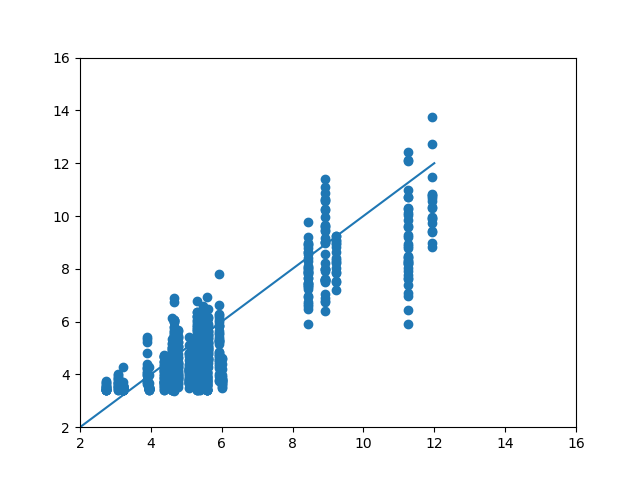

In [64]:
%matplotlib widget
plot_against(best_model, data_preparation(im_test), label_test)

In [66]:
save_path = os.path.join(storage_path, "models", "model_vendredi")
best_model.save(save_path)

2022-08-12 16:34:00.585513: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets
2022-08-12 16:34:02,605-[INFO]- tensorflow:779 -> Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets


In [38]:
best_model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 6ms/step - loss: 2.2786 - mean_absolute_error: 1.0133


[2.278571844100952, 1.0132561922073364]

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 111, 160)          1760      
                                                                 
 re_lu (ReLU)                (None, 111, 160)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 102, 128)          204928    
                                                                 
 re_lu_1 (ReLU)              (None, 102, 128)          0         
                                                                 
 average_pooling1d (AverageP  (None, 51, 128)          0     

In [40]:
tuner.get_best_models(5)

2022-06-07 15:53:58,773-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-06-07 15:53:58,774-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-06-07 15:53:58,775-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-06-07 15:53:58,777-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-06-07 15:53:58,778-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-06-07 15:53:58,779-[WARNI

### Evaluate with data augmentation

In [49]:
from amftrack.ml.width.data_augmentation import *

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(120),
        # random_invert(p=0.5),  # TODO(FK): keep?
        random_mirror(p=0.5),
        random_brightness(20),
    ]
)

In [50]:
data_preparation

In [42]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [44]:
test_label.shape

(74, 1)

In [45]:
test_feature_ = data_augmentation(test_feature)

TensorShape([1, 80, 1])

In [ ]:
best_model.evaluate(test_feature, test_label)

In [41]:
data_augmentation

## BROUILLON

In [276]:
e

(<tf.Tensor: shape=(32, 80, 1), dtype=float32, numpy=
 array([[[130.],
         [130.],
         [130.],
         ...,
         [127.],
         [128.],
         [129.]],
 
        [[113.],
         [111.],
         [109.],
         ...,
         [129.],
         [128.],
         [125.]],
 
        [[119.],
         [120.],
         [120.],
         ...,
         [122.],
         [123.],
         [122.]],
 
        ...,
 
        [[146.],
         [144.],
         [141.],
         ...,
         [148.],
         [147.],
         [147.]],
 
        [[110.],
         [107.],
         [106.],
         ...,
         [116.],
         [115.],
         [114.]],
 
        [[124.],
         [124.],
         [124.],
         ...,
         [124.],
         [123.],
         [123.]]], dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([7.26221294, 5.93755418, 5.5774322 , 4.19787153, 3.7441611 ,
        5.20109506, 4.87914297, 0.        , 8.52101685, 8.73503977,
        4.5910988

TEST 1

In [125]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

TEST 2

In [186]:
data_augmentation(train_feature)[:3, :3]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[131.],
        [130.],
        [129.]],

       [[130.],
        [130.],
        [128.]],

       [[130.],
        [131.],
        [131.]]], dtype=float32)>

TEST 3

In [187]:
help(tuner.search)

Help on method search in module keras_tuner.engine.base_tuner:

search(*fit_args, **fit_kwargs) method of keras_tuner.tuners.randomsearch.RandomSearch instance
    Performs a search for best hyperparameter configuations.
    
    Args:
        *fit_args: Positional arguments that should be passed to
          `run_trial`, for example the training and validation data.
        **fit_kwargs: Keyword arguments that should be passed to
          `run_trial`, for example the training and validation data.



TEST 4: making an augmented dataset from the tensor

In [188]:
help(tf.data.Dataset)

Help on class DatasetV2 in module tensorflow.python.data.ops.dataset_ops:

class DatasetV2(collections.abc.Iterable, tensorflow.python.training.tracking.base.Trackable, tensorflow.python.framework.composite_tensor.CompositeTensor)
 |  DatasetV2(variant_tensor)
 |  
 |  Represents a potentially large set of elements.
 |  
 |  The `tf.data.Dataset` API supports writing descriptive and efficient input
 |  pipelines. `Dataset` usage follows a common pattern:
 |  
 |  1. Create a source dataset from your input data.
 |  2. Apply dataset transformations to preprocess the data.
 |  3. Iterate over the dataset and process the elements.
 |  
 |  Iteration happens in a streaming fashion, so the full dataset does not need to
 |  fit into memory.
 |  
 |  Source Datasets:
 |  
 |  The simplest way to create a dataset is to create it from a python `list`:
 |  
 |  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |  >>> for element in dataset:
 |  ...   print(element)
 |  tf.Tensor(1, sh

In [ ]:
  file_path_features = [data_path_from_slice_path(path) for path in file_paths]

    both_path = tf.data.Dataset.from_tensor_slices(
        [list(couple) for couple in zip(file_paths, file_path_features)]
    )
    general_dataset = both_path.interleave(single_slice_dataset, cycle_length=n_readers)
    general_dataset = general_dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return general_dataset.batch(1)  # Output shape: (1, 120, 1)
    # TODO(FK): remove the batching here and the prefetch  .prefetch(1)

In [197]:
train_feature.shape

(527, 120)

In [219]:
prov = np.expand_dims(train_feature[4, :], axis=0)

In [220]:
prov.shape

(1, 120)

In [236]:
prov = np.expand_dims(train_feature[4, :], axis=-1)
prov = np.expand_dims(prov, axis=0)
prov.shape

(1, 120, 1)

In [143]:
def random_crop(output_size):
    # TODO(FK): add name
    # TODO(FK): handle size
    size = [74, output_size, 1]
    return tf.keras.layers.Lambda(lambda x: tf.image.random_crop(x, size=size))


@tf.function
def center_crop_slice(x, margin):
    return x[..., margin:-margin, :]


def center_crop(input_size=120, output_size=80):
    return tf.keras.layers.Lambda(
        lambda x: center_crop_slice(x, (input_size - output_size) // 2)
    )


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
        # random_invert(p=0.5),  # TODO(FK): keep?
        # random_mirror(p=0.5),
        # random_brightness(10),
    ]
)

In [100]:
from amftrack.ml.width.data_augmentation import *

In [79]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
    ]
)

In [132]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [144]:
feature_vector = data_augmentation(test_feature)

In [145]:
tf.random.set_seed(12)

In [146]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [147]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [148]:
best_model.evaluate(feature_vector, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 5.2993 - mean_absolute_error: 1.2498


[5.299310207366943, 1.2498197555541992]

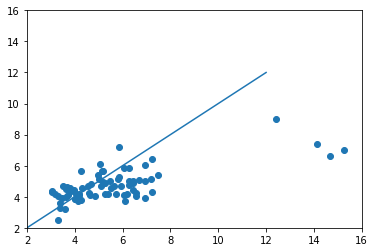

In [149]:
plot_against(best_model, feature_vector, test_label)

In [237]:
data_augmentation(prov)

<tf.Tensor: shape=(1, 80, 1), dtype=float32, numpy=
array([[[117.],
        [115.],
        [116.],
        [117.],
        [118.],
        [117.],
        [118.],
        [119.],
        [118.],
        [120.],
        [123.],
        [123.],
        [124.],
        [125.],
        [126.],
        [127.],
        [131.],
        [130.],
        [131.],
        [136.],
        [138.],
        [140.],
        [145.],
        [156.],
        [163.],
        [160.],
        [152.],
        [140.],
        [132.],
        [131.],
        [126.],
        [124.],
        [124.],
        [123.],
        [122.],
        [118.],
        [119.],
        [121.],
        [124.],
        [125.],
        [121.],
        [122.],
        [122.],
        [121.],
        [121.],
        [120.],
        [118.],
        [119.],
        [120.],
        [119.],
        [116.],
        [118.],
        [118.],
        [117.],
        [118.],
        [119.],
        [119.],
        [117.],
        [115.],
    

In [200]:
train_feature[5, :].shape

(120,)

In [205]:
type(train_label[1])

numpy.ndarray

In [207]:
type(np.array(train_feature[6, :]))

numpy.ndarray

In [209]:
len(train_feature)

527

In [210]:
both_path = tf.data.Dataset.from_tensor_slices(
    [
        list(couple)
        for couple in zip(
            [np.array(train_feature[i, :]) for i in range(len(train_feature))],
            train_label,
        )
    ]
)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [232]:
train_feature.shape

(527, 120)

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [230]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature)
d1_ = d1.map(lambda x: np.expand_dims(x, 0))

NotImplementedError: in user code:

    File "/tmp/ipykernel_21812/3081659417.py", line 2, in None  *
        lambda x: np.expand_dims(x, 0)
    File "<__array_function__ internals>", line 180, in expand_dims  **
        
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/numpy/lib/shape_base.py", line 591, in expand_dims
        a = asanyarray(a)

    NotImplementedError: Cannot convert a symbolic Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [227]:
d2 = tf.data.Dataset.from_tensor_slices(train_label)
d3 = tf.data.Dataset.zip((d1, d2))

In [225]:
train = (
    d3.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 18:05:48,465-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1607789451.py", line 2, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


## BROUILLON

In [66]:
train_feature.shape

(377, 120)

In [77]:
prov = np.expand_dims(train_feature, axis=-1).shape

In [79]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors, name=None)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    

In [78]:
train_ds = tf.data.Dataset.from_tensor_slices(prov)

ValueError: Unbatching a tensor is only supported for rank >= 1

In [69]:
for e in train_ds:
    print(e.shape)

(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(

In [65]:
data_preparation(train_feature).shape

TensorShape([377, 80, 1])

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_feature)
train_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(120,), dtype=tf.uint8, name=None)>

In [57]:
train = (
    train_dataset.map(lambda x: (data_augmentation(x, training=True)))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 16:51:06,205-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1439737797.py", line 2, in None  *
        lambda x: (data_augmentation(x, training=True))
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


In [55]:
train_dataset = (
    train_dataset.map(data_augmentation)
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 16:49:36,925-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).

in user code:

    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
        return x[..., start_index : start_index + input_size, :]

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


Call arguments received:
  • inputs=tf.Tensor(shape=(120,), dtype=float32)
  • mask=None
  • training=False